# Preliminaries + Installs

These instructions are for Python 3.10
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy pypdf langchain-unstructured "unstructured[pdf]" --user`
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

Could not load data/state.json!
[Errno 2] No such file or directory: 'data/state.json'


## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
from os import path, makedirs
from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =  "50"
environ["_RAG_DOC_LIMIT"]  = "250"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"
environ["_RAG_VEC_DBASE"]  = "lit_vec"


## Determine if more docs will be loaded this session

In [4]:
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient()
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] )

environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-collection.count(), int(environ["_RAG_DOC_ADD"]) ) )

print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs()

50 files will be copied!
.

## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [5]:
import os
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    pdfs_drct = environ["_RAG_PDF_DESTIN"]
    fNames    = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]
    print( f"Copied {len(fNames)} files!" )
    pages = deque() # Fast append
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            loader    = PyPDFLoader( file_path )
            async for page in loader.alazy_load():
                pages.append( page )
            print( f"{i+1}:{len(pages)}", end = ', ', flush = True )
            RAGstate['libDocs'].append( file_path )
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0} minutes!" )

save_state()

Copied 50 files!
1:15, 2:22, 3:27, 4:39, 5:52, 6:66, 7:77, 8:87, 9:106, 10:127, 11:135, 12:152, 13:196, 14:218, 15:250, 16:283, 17:309, 18:326, 19:336, 20:348, 21:361, 22:379, 23:387, 24:399, 25:424, 26:435, 27:458, 28:517, 29:523, 30:541, 31:555, 32:567, 33:575, 34:585, 35:605, 36:626, 37:639, 38:666, 39:674, 

Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 122 0 (offset 0)
Ignoring wrong pointing object 127 0 (offset 0)
Ignoring wrong pointing object 132 0 (offset 0)
Ignoring wrong pointing object 134 0 (offset 0)
Ignoring wrong pointing object 143 0 (offset 0)
Ignoring wrong pointing object 148 0 (offset 0)
Ignoring wrong pointing object 153 0 (offset 0)
Ignoring wrong pointing object 155 0 (offset 0)
Ignoring wrong pointing object 223 0 (offset 0)
Ignoring wrong pointing object 225 0 (offset 0)
Ignoring wrong pointing object 227 0 (offset 0)
Ignoring wrong pointing object 229 0 (offset 0)
Ignoring wrong pointing object 231 0 (offset 0)
Ignoring wrong pointing object 233 0 (offset 0)
Ignoring wrong pointing object 235 0 (offset 0)
Ignoring wrong pointing object 237 0 (offset 0)
Ignoring wrong pointing object 239 0 (offset

40:715, 41:727, 42:738, 43:1107, 44:1125, 45:1160, 46:1179, 47:1194, 48:1217, 49:1228, 50:1237, 
Read 1237 pages in 0.7728346864382426 minutes!


In [6]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [7]:

import sys, os, time
now = time.time


# from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
# from langchain_community import embeddings

# pull_ollama_model( "nomic-embed-text" ) # Dimension too big
pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [8]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap()
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [9]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts = [str( pg.page_content ) for pg in pages]
    metaDt = list()

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        # Save PDF Page image #
        pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
        pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
        
        with open( pkl_i, 'wb' ) as f:
            RAGstate['pages'][ id_i ] = str( pkl_i )
            pickle.dump( pgPic, f )
    
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0} minutes!" )

save_state()



Added 1237 documents in 1.8039393623669941 minutes!


# Create vector store

In [10]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn)} seconds!" )

Built vector store in 0.0024013519287109375 seconds!


# Load VLM

In [11]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [12]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()
parser    = JsonOutputParser()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [13]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [14]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [20]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn} seconds to process!" )
        pprint( response.content )

(' The article discusses the challenges of robotic assembly due to '
 'manufacturing tolerances, positioning errors, sensing and control errors, '
 'and the importance of compliant motion in overcoming these challenges. It '
 'highlights the use of passive devices such as the remote centre compliance '
 '(RCC) and active compliance as alternatives to achieve robust assembly '
 'performance.\n'
 '\n'
 'The author proposes a learning approach for robotic assembly using '
 'multimodal information, including vision templates and force sensing. The '
 'proposed methodology includes the description of the test bed, image '
 'processing, task description, and knowledge acquisition. The results of this '
 'study are explained in Section 4.\n'
 '\n'
 'In related work, the article cites several publications that have dealt with '
 'active compliance using connectionist models in robot control to solve a '
 'canonical assembly task like the PIH operation under uncertainty. However, '
 'the networ

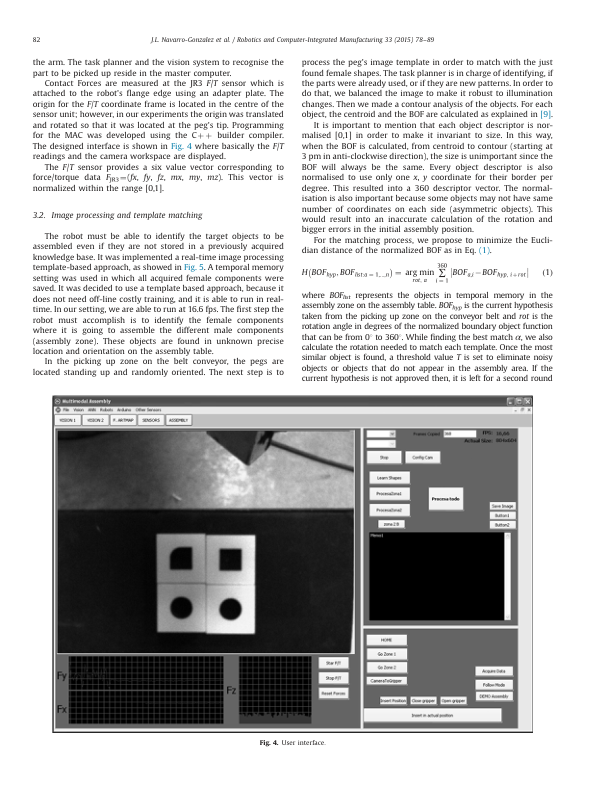

LLM query took 32.040202379226685 seconds to process!
(" The image you've shared appears to be from a research paper or academic "
 'publication. However, the content of the document is not fully visible, and '
 'it seems to contain an article related to robotics, possibly involving '
 'robotic assembly processes. While I can comment on the aspects typically '
 'important for robotic assembly, the actual content of your image would '
 'provide more insight into the specific details regarding this topic.\n'
 '\n'
 'In general, important aspects of robotic assembly include:\n'
 '\n'
 '1. Precision and accuracy: Robots need to be highly precise in placing parts '
 'or manipulating objects to ensure the quality of the final product.\n'
 '\n'
 '2. Flexibility: The ability for a robot to handle various types and sizes of '
 'components is crucial for adaptability to different assembly tasks.\n'
 '\n'
 '3. Adaptability: Robots should have the capacity to learn new tasks, adjust '
 'to changes

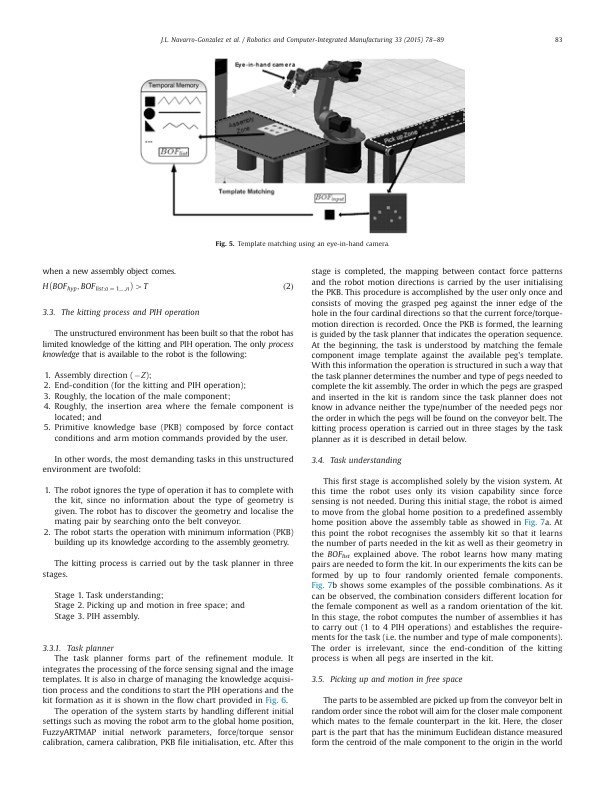

LLM query took 28.845249891281128 seconds to process!
(" The image you've provided appears to be a page from a book or an academic "
 'paper, detailing some of the key aspects of robotic assembly. While I cannot '
 'provide specific details about the text without further context, I can infer '
 'that the important aspects likely discussed in the article include:\n'
 '\n'
 '1. **Robot Design and Integration**: This would cover how to design and '
 'integrate a robot for assembly tasks. It could include choosing the right '
 'hardware and software components and integrating them effectively.\n'
 '\n'
 '2. **Assembly Process Planning**: The planning of how the robot will go '
 'about assembling parts, including path planning, tool changes, and material '
 'handling.\n'
 '\n'
 '3. **Safety and Precision**: Discussing safety measures to prevent accidents '
 'during robotic assembly, as well as ensuring precision in component '
 'placement.\n'
 '\n'
 "4. **Efficiency and Optimization**: How 

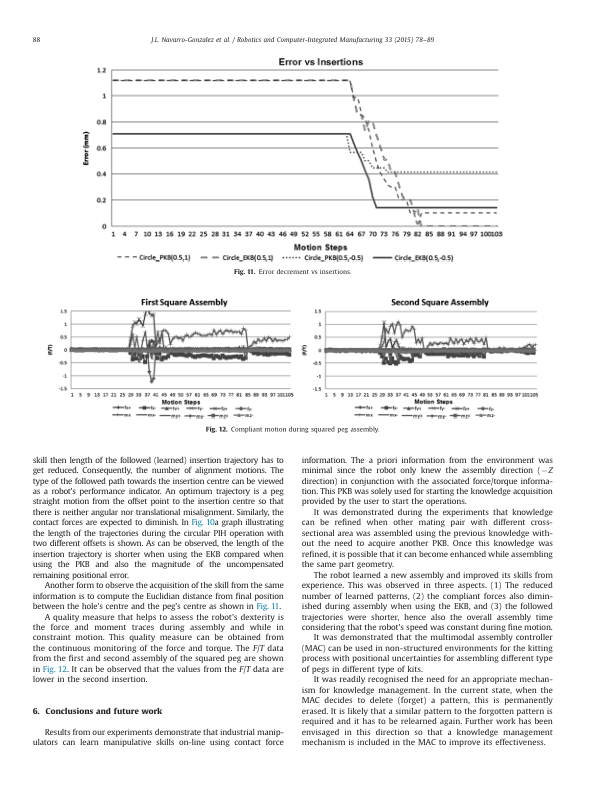

LLM query took 36.77690887451172 seconds to process!
(" The image you've provided appears to be a page from a research paper or "
 'academic article discussing important aspects of robotic assembly. While the '
 'specific content and details are not entirely clear due to the resolution, I '
 'can make some general observations based on common topics in such '
 'literature:\n'
 '\n'
 '1. **Control Systems**: Robotic systems typically require sophisticated '
 'control systems to coordinate the movement and actions of the robot end '
 'effector (the part that interacts with the environment). These systems often '
 'incorporate machine learning or artificial intelligence for better '
 'decision-making and adaptability.\n'
 '\n'
 '2. **Task Planning**: Efficient task planning is crucial to ensure that '
 'robots can perform a sequence of tasks in an optimal manner, minimizing '
 'errors and improving productivity.\n'
 '\n'
 '3. **Force Control**: Robots need to apply appropriate forces when

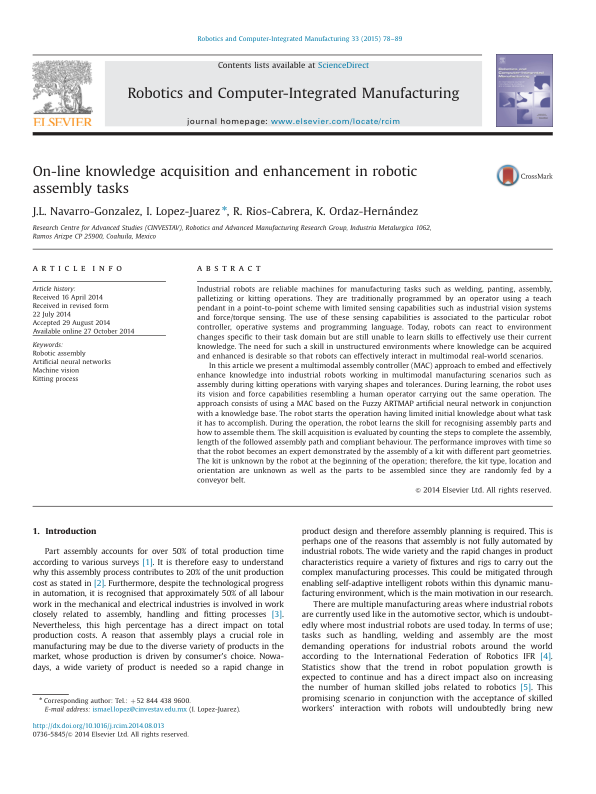

LLM query took 42.07396054267883 seconds to process!
(" The image you've provided appears to be a page from a scientific or "
 'engineering journal discussing the topic of robotic assembly, specifically '
 'focusing on the "knowledge acquisition and enhancement in robotics."\n'
 '\n'
 'The important aspects mentioned in the text related to this topic could '
 'include:\n'
 '\n'
 '1. **Knowledge Acquisition**: The process by which a robot learns how to '
 'perform tasks by observing humans or learning from predefined rules. This '
 'involves understanding and interpreting the environment, including physical '
 'objects and actions, as well as any relevant rules or knowledge bases.\n'
 '\n'
 '2. **Enhancement**: Once the robot has acquired knowledge, it needs to '
 'enhance its capabilities to improve performance. Enhancement could involve '
 'refining existing skills, learning new ones, or adapting to different '
 'contexts and tasks.\n'
 '\n'
 '3. **Robotics and Computer Integration**:

In [21]:
deep_doc_ask( "What are the important aspects of robotic assembly?" )